In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import math
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [2]:
team_records_initial = pd.read_csv('records.csv')[['year','team','team_wins','team_losses','team_ties','playoffs']]
df_initial = pd.read_csv('bref.csv')

In [3]:
#team abbrevations changed over the years (for example KCA/PHA/OAK) as teams move or names change,
#so mapping them to 1 org

master_org_dict = {'MON':'WSN',
                   'CAL':'LAA',
                   'WSA':'TEX',
                   'SEP':'MIL',
                   'KCA':'OAK',
                   'MLN':'ATL',
                   'FLA':'MIA',
                   'TBD':'TBR',
                   'WSH':'MIN',
                   'NYG':'SFG',
                   'BRO':'LAD',
                   'PHA':'OAK',
                   'SLB':'BAL',
                   'BSN':'ATL',
                   'ANA':'LAA'
                  }

recs = team_records_initial.copy()
recs['master_team'] = recs['team'].apply(lambda x: master_org_dict[x] if x in master_org_dict else x)
recs2 = recs.copy()
for col in ['team_wins','team_losses','team_ties']:
    recs2 = recs2.rename(columns={col:'%s_prior_year' % col})
recs2['year'] = recs2['year'] + 1
    
recs = pd.merge(recs,recs2,on=['year','team','playoffs','master_team'],how='left')

In [4]:
#couldn't figure out how to denserank within cumcount so went about in a roundabout way
def get_metric_based_rank(data_frame,metrics,asc_or_desc=False):
    for metric in metrics:
        rank_metric = '%s_rank_initial' % metric
        data_frame[rank_metric] = data_frame.sort_values([metric], ascending=[asc_or_desc]).groupby(['year','league']).cumcount() + 1
        test_df = data_frame.copy()
        group = ['league','year',metric]
        test_df = test_df[group+[rank_metric]].groupby(group).min().reset_index()
        test_df = test_df.rename(columns={rank_metric:rank_metric.replace('_initial','')})
        data_frame = pd.merge(data_frame,test_df,on=group,how='left')
    return data_frame

In [5]:
def adjust_data_frame(data_frame):
    for val in ['','_prior_year']:
        win_col = 'team_wins%s' % val
        loss_col = 'team_losses%s' % val
        tie_col = 'team_ties%s' % val
        
        data_frame['team_games_played%s' % val] = data_frame[win_col] + data_frame[loss_col] + data_frame[tie_col]
        data_frame['team_win_pct%s' % val] = data_frame[win_col] / (data_frame[loss_col] + data_frame[win_col])
    data_frame['decade'] = data_frame['year'].apply(lambda x: str(x)[:3] + '0s')
    for col in ['wins','saves']:
        data_frame[col] = data_frame[col].fillna(0)
    data_frame['wins_saves'] = data_frame['wins'] + data_frame['saves']
    data_frame = data_frame.loc[data_frame.wins_saves==0,:]
    data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
    data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
    data_frame['runs_produced'] = data_frame['runs'] + data_frame['rbi'] - data_frame['home_runs']
    data_frame['90_win_pace'] = data_frame['team_win_pct'] >.555
    
    data_frame['name'] = data_frame['name'].apply(lambda x: x.split(',')[1] + ' ' + x.split(',')[0])
    return data_frame

In [6]:
#function for adding formatting to the graphs
def format_graph(xlab,ylab,title,legend_dims=None,legend_title=None):
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    
    if legend_dims:
        plt.legend(bbox_to_anchor=legend_dims, loc=1, borderaxespad=0.,title=legend_title)

In [7]:
#joining stats and records data frames together

df = df_initial.copy()
df = pd.merge(df,recs,on=['team','year'],how='left')
df = adjust_data_frame(df)
df = get_metric_based_rank(df,['voting_place'],True)
df['voting_place'] = df['voting_place_rank']
df['winner'] = df['voting_place'] == 1

<ipython-input-5-c23543da9d85>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['wins_improvement'] = data_frame['team_wins'] + data_frame['team_wins_prior_year']
<ipython-input-5-c23543da9d85>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame['win_pct_improvement'] = data_frame['team_win_pct'] + data_frame['team_win_pct_prior_year']
<ipython-input-5-c23543da9d85>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [8]:
#get max mean and standard deviations for metrics for a year
def get_statical_measures(data_frame,calc_type,stats):
    if calc_type == 'max':
        stat_df = data_frame[group_cols + stats].groupby(group_cols).max().reset_index()
    elif calc_type == 'std':
        stat_df = data_frame[group_cols + stats].groupby(group_cols).std().reset_index()
    elif calc_type == 'mean':
        stat_df = data_frame[group_cols + stats].groupby(group_cols).mean().reset_index()

    for val in stats:
        stat_df = stat_df.rename(columns={val:'%s_%s' % (calc_type,val)})
        
    data_frame = pd.merge(data_frame,stat_df,on=['year','league'],how='left')
    return data_frame

In [9]:
group_cols = ['year','league']
stats = ['war','rbi','runs','home_runs','team_wins','average','obp','slg','ops','sb','team_win_pct','win_pct_improvement','wins_improvement','runs_produced']

for calc_type in ['mean','max','std']:
    df = get_statical_measures(df,calc_type,stats)

#calculate difference from league leader and standard deviations from mean for different stats
for col in stats:
    diff_col = '%s_difference' % col
    max_col = 'max_%s' % col
    std_col = 'std_%s' % col
    mean_col = 'mean_%s' % col
    
    df[diff_col] =  df[max_col] - df[col]
    df['%s_leader' % col] = df[diff_col] == 0
    
    std_from_mean_col = '%s_std_from_mean' % col
    df[std_from_mean_col] = (df[col] - df[mean_col]) / df[std_col]
    df[std_from_mean_col] = df[std_from_mean_col].fillna(0.0)
    
    
#get players rank in each statistical category
df = get_metric_based_rank(df,stats)
df['triple_crown_agg_rank'] = df['rbi_rank'] + df['home_runs_rank'] + df['average_rank']
df['expected_vote_place_difference'] = df['war_rank'] - df['voting_place']
df = df.sort_values('decade',ascending=True)

In [10]:
#create data frame league leaders only
league_leaders_df = pd.DataFrame()

for stat in stats:
    temp = df.loc[df['%s_difference' % stat]==0][['year','team_win_pct','win_pct_improvement','decade','league','voting_place','playoffs','winner','name']]
    temp['metric'] = stat
    league_leaders_df = pd.concat([league_leaders_df,temp])

How League Leaders Of Various Categories Do In Voting Over Time

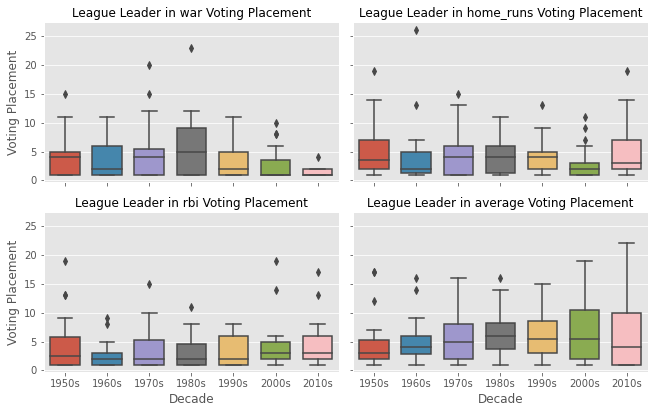

In [11]:
sns.catplot(x="decade", y="voting_place",
                 col="metric",
                data=league_leaders_df[league_leaders_df['metric'].isin(['average','home_runs','rbi','war'])]\
            .sort_values('decade',ascending=True), kind="box",col_wrap=2,
                height=2.8,aspect=1.6, width=0.7).set_axis_labels(x_var='Decade',y_var='Voting Placement')\
.set_titles('League Leader in {col_name} Voting Placement')

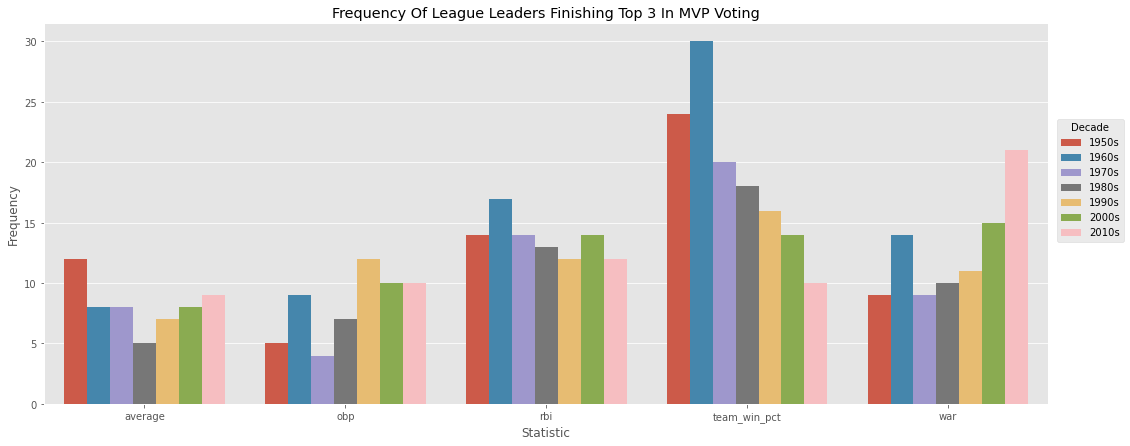

In [12]:
plt.figure(figsize=(18,7))
grouped_df = league_leaders_df.loc[league_leaders_df.voting_place<=3].groupby(['decade','metric']).count().reset_index()
sns.barplot(x='metric', y='name', data=grouped_df.loc[grouped_df.metric.isin(['team_win_pct','war','rbi','obp','average'])], hue="decade")

format_graph('Statistic','Frequency','Frequency Of League Leaders Finishing Top 3 In MVP Voting',(1.075, 0.75),legend_title='Decade')

How and players triple crown rank and WAR correlated with MVP voting results over time, and how being a good team impacted things

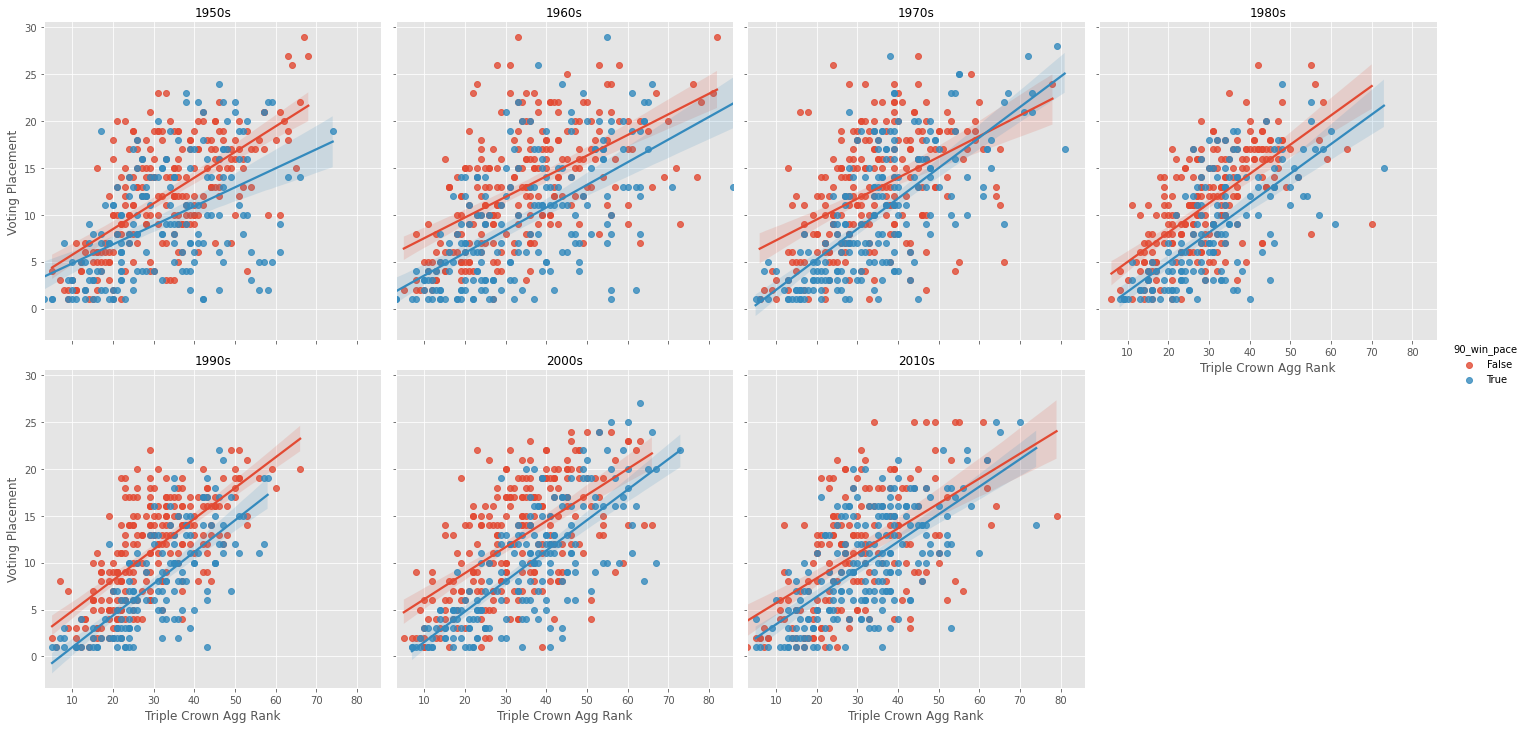

In [13]:
sns.lmplot(x="triple_crown_agg_rank", y="voting_place",data=df.sort_values('decade',ascending=True),
           col="decade",hue='90_win_pace',col_wrap=4).set_axis_labels(x_var='Triple Crown Agg Rank',y_var='Voting Placement').set_titles('{col_name}')

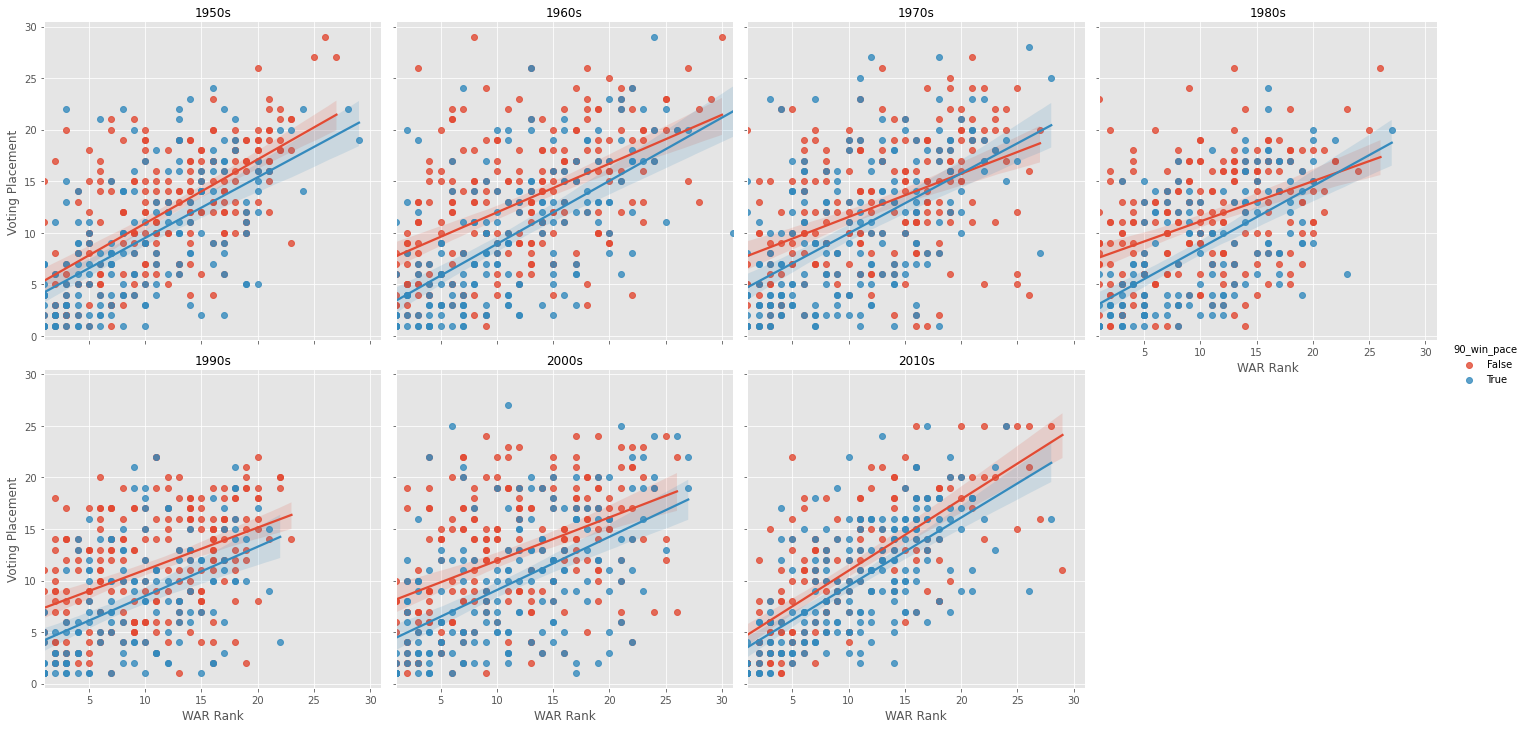

In [14]:
sns.lmplot(x="war_rank", y="voting_place",data=df.sort_values('decade',ascending=True),col="decade",hue='90_win_pace',col_wrap=4).set_axis_labels(x_var='WAR Rank',y_var='Voting Placement').set_titles('{col_name}')

MVP Winners and how close they were to leading league and war and the war difference YoY by league

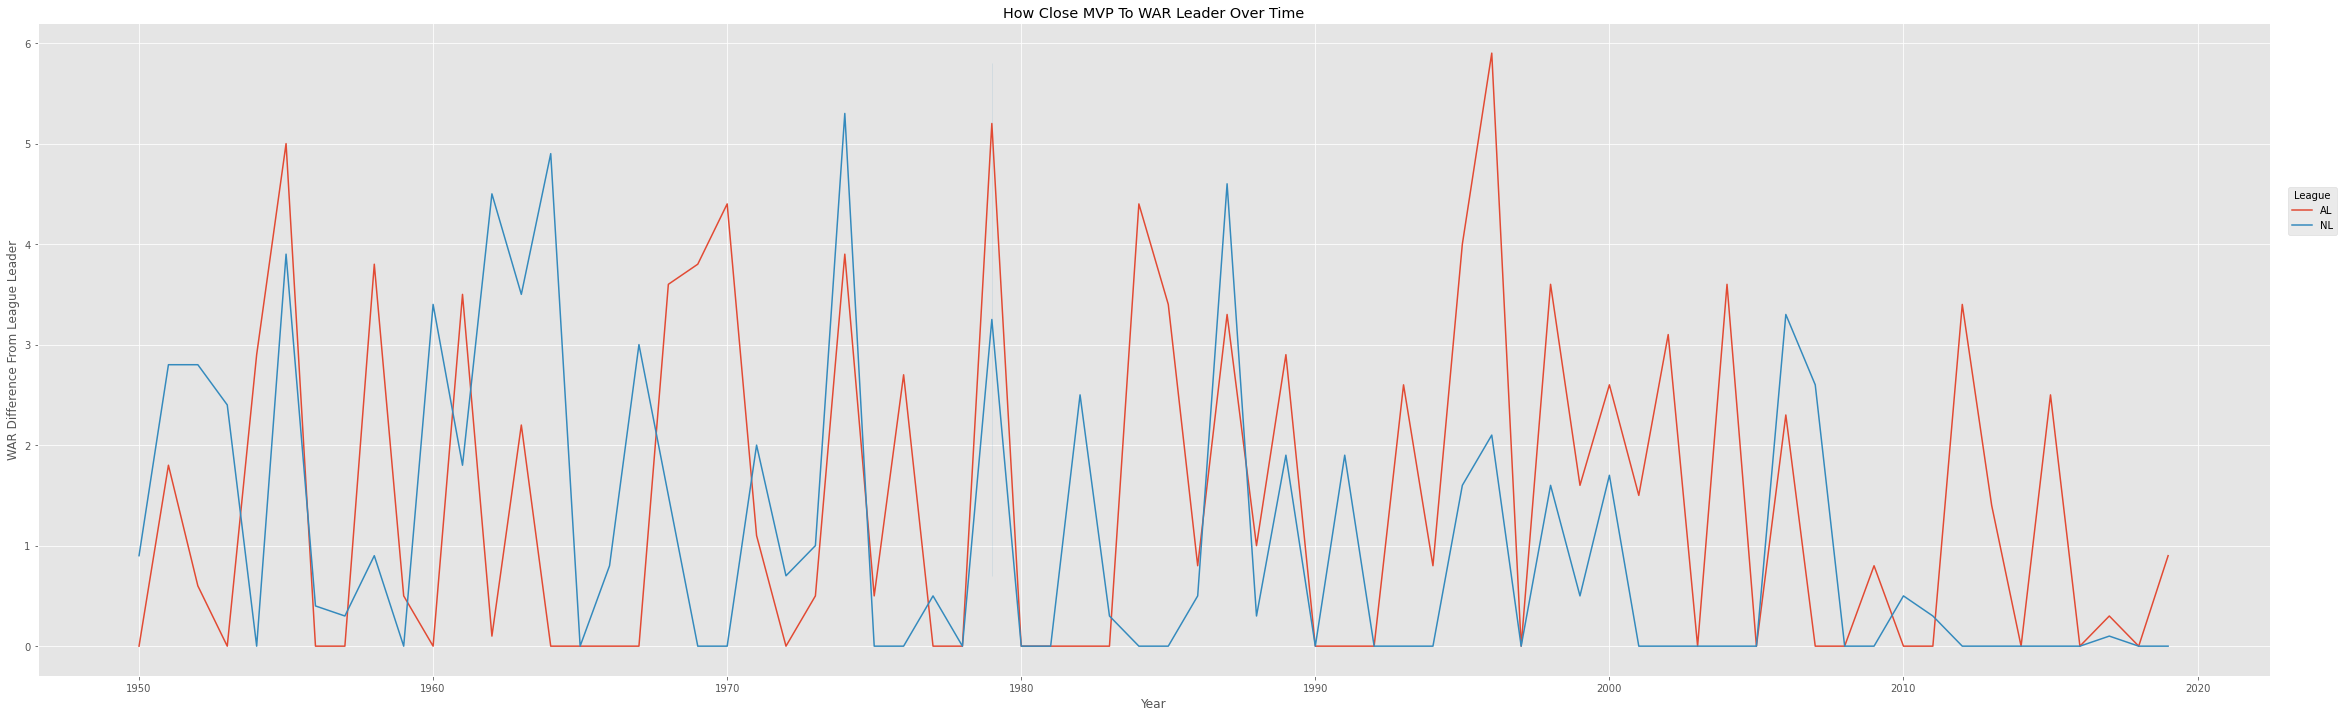

In [15]:
plt.figure(figsize=(40,12))
sns.lineplot(x='year', y='war_difference', data=df.loc[df.winner==True],hue='league')

format_graph('Year','WAR Difference From League Leader','How Close MVP To WAR Leader Over Time',(1.03, 0.75),legend_title='League')

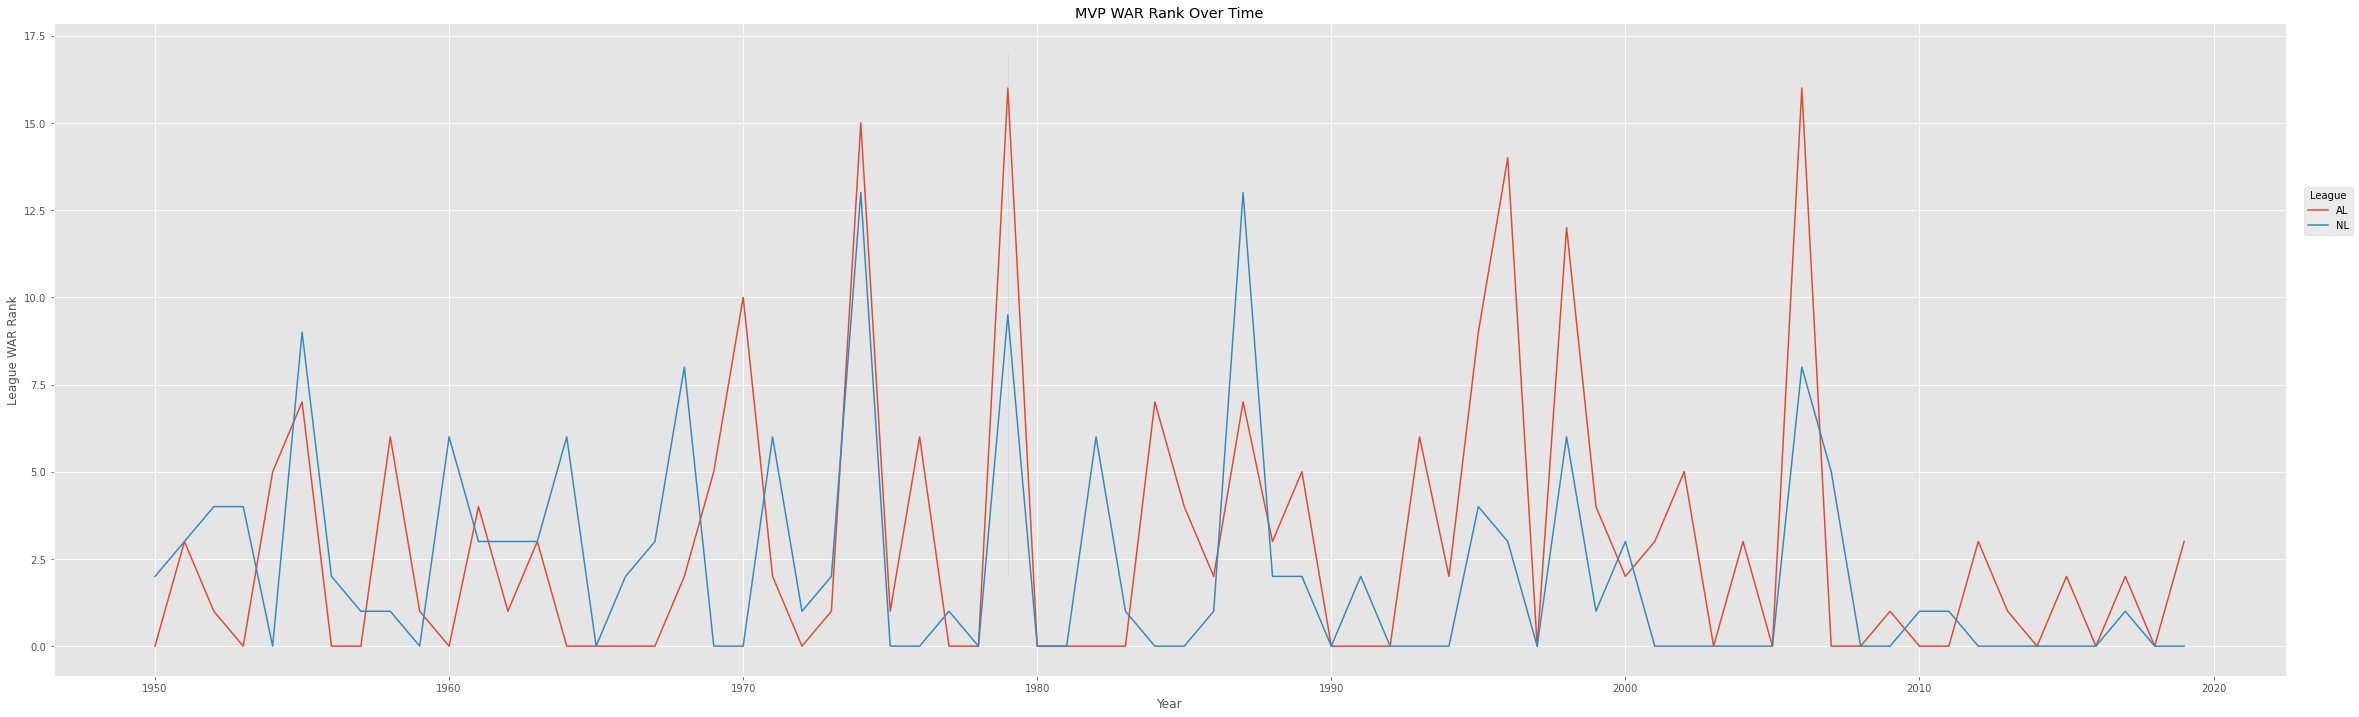

In [16]:
plt.figure(figsize=(40,12))
sns.lineplot(x='year', y='expected_vote_place_difference', data=df.loc[df.winner==True],hue='league')
format_graph('Year','League WAR Rank','MVP WAR Rank Over Time',(1.03, 0.75),legend_title='League')

Top and Bottom 10 players in how they have performed in MVP voting vs WAR rank

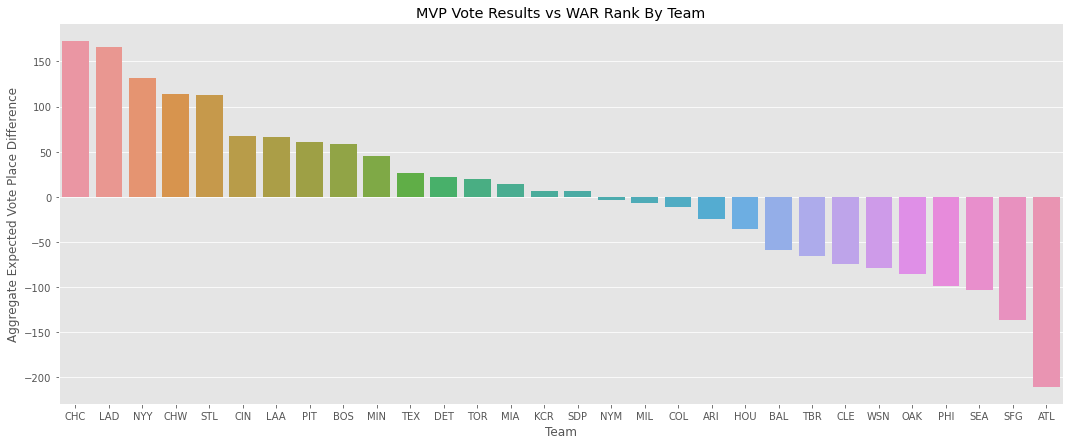

In [17]:
plt.figure(figsize=(18,7))
sns.barplot(x='master_team', y='expected_vote_place_difference', data=df.groupby(['master_team']).sum().reset_index().sort_values('expected_vote_place_difference',ascending=False))

format_graph('Team','Aggregate Expected Vote Place Difference','MVP Vote Results vs WAR Rank By Team')


Top and Bottom 10 players in how they have performed in MVP voting vs WAR rank

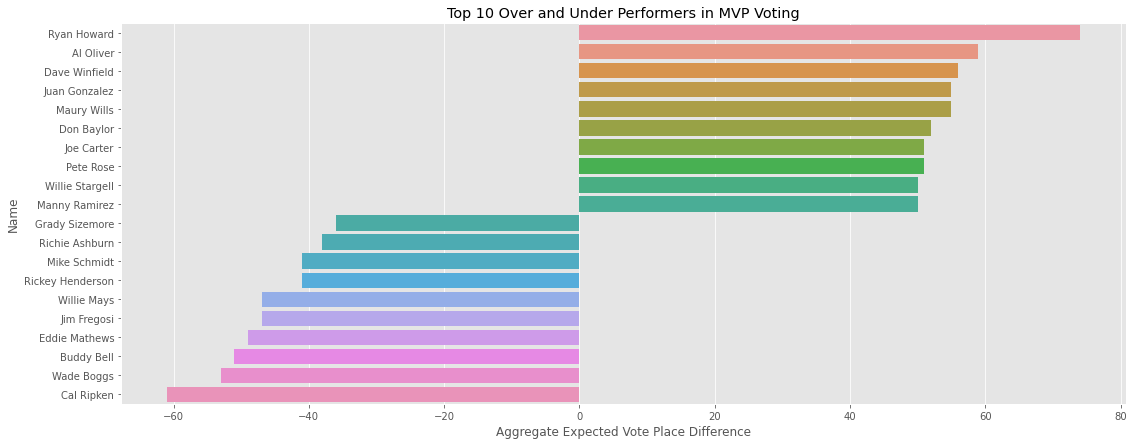

In [18]:
plt.figure(figsize=(18,7))
grouped_df = df.groupby(['name']).sum().reset_index().sort_values('expected_vote_place_difference',ascending=False)
sns.barplot(x='expected_vote_place_difference', y='name', data=pd.concat([grouped_df[:10],grouped_df[-10:]]),orient='h')

format_graph('Aggregate Expected Vote Place Difference','Name','Top 10 Over and Under Performers in MVP Voting')



How extreme performance in certain categories may lead to automatic high voting finish

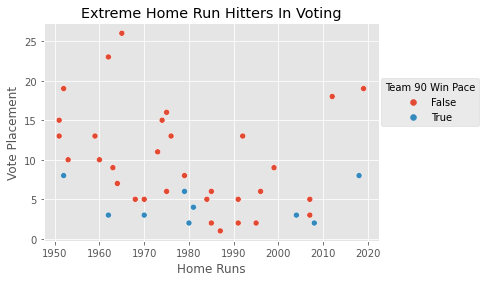

In [19]:
sns.scatterplot(x="year", y="voting_place",data=df.loc[df.home_runs_std_from_mean>=1.5].loc[df.war_rank>10],x_jitter=True,hue='90_win_pace')
format_graph('Home Runs','Vote Placement','Extreme Home Run Hitters In Voting',(1.3, 0.75),legend_title='Team 90 Win Pace')

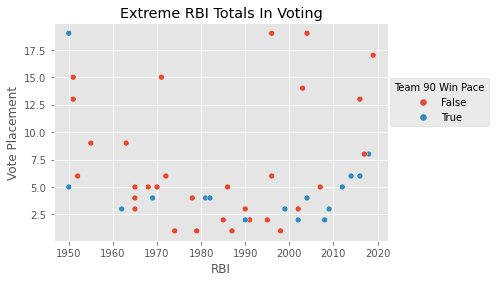

In [20]:
sns.scatterplot(x="year", y="voting_place",data=df.loc[df.rbi_std_from_mean>=1.5].loc[df.war_rank>10],x_jitter=True,hue='90_win_pace')
format_graph('RBI','Vote Placement','Extreme RBI Totals In Voting',(1.3, 0.75),legend_title='Team 90 Win Pace')

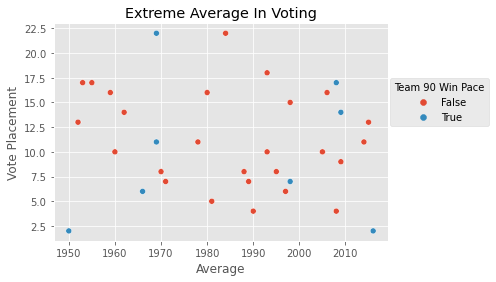

In [21]:
sns.scatterplot(x="year", y="voting_place",data=df.loc[df.average_std_from_mean>=1.5].loc[df.war_rank>10],x_jitter=True,hue='90_win_pace')
format_graph('Average','Vote Placement','Extreme Average In Voting',(1.3, 0.75),legend_title='Team 90 Win Pace')

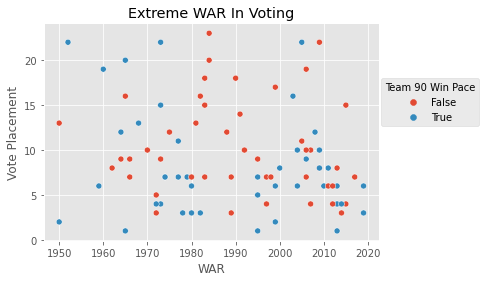

In [22]:
sns.scatterplot(x="year", y="voting_place",data=df.loc[df.war_std_from_mean>=1].loc[df.rbi_rank>5].loc[df.home_runs_rank>5].loc[df.average_rank>5],x_jitter=True,hue='90_win_pace')
format_graph('WAR','Vote Placement','Extreme WAR In Voting',(1.3, 0.75),legend_title='Team 90 Win Pace')